In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import math
import random
import os
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from google.colab import drive
import datetime as dt
from scipy.interpolate import make_interp_spline
from sklearn import metrics

In [2]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [3]:
all_classes = os.listdir('/content/drive/MyDrive/Full_Training_Data')

FileNotFoundError: ignored

In [ ]:
all_classes

['non_scoring_clips', 'scoring_clips']

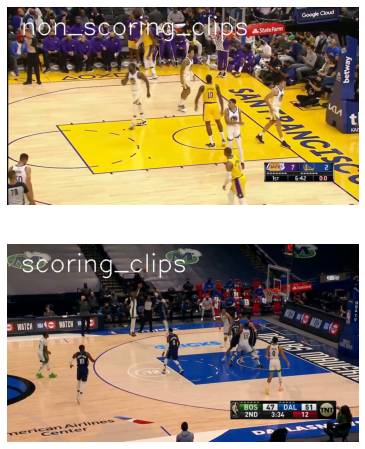

In [ ]:
counter = 1
frames=3
plt.figure(figsize=(15,8))
for index in range(len(all_classes)):
  class_name = all_classes[index]
  video_files = os.listdir(f'/content/drive/MyDrive/Full_Training_Data/{class_name}')
  video_file = random.choice(video_files)

  video_reader = cv2.VideoCapture(f'/content/drive/MyDrive/Full_Training_Data/{class_name}/{video_file}')
  _,bgr_frame = video_reader.read()

  video_reader.release()

  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

  cv2.putText(rgb_frame, class_name, (50,100), cv2.FONT_HERSHEY_SIMPLEX, 3, (255,255,255), 3)

  plt.subplot(2,1,counter)
  plt.imshow(rgb_frame)
  plt.axis('off')
  counter+=1

In [4]:
IMAGE_HEIGHT, IMAGE_WIDTH = 65,65
SEQUENCE_LENGTH = 25
DATASET_DIR = 'drive/MyDrive/Training_Data'

CLASSES_LIST = ['non_scoring_clips', 'scoring_clips']

In [5]:
def frames_extraction(video):
  frames_list = []
  video_reader = cv2.VideoCapture(video)
  
  total_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_window = max(int(total_frames/SEQUENCE_LENGTH), 1)

  for counter in range(SEQUENCE_LENGTH):
    video_reader.set(cv2.CAP_PROP_FRAME_COUNT, counter*skip_window)
    success, frame = video_reader.read()

    if not success:
      break
    
    else:
      resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

      normalised = resized_frame/255

      frames_list.append(normalised)

  video_reader.release()
  return frames_list

In [6]:
def create_dataset():
  features = []
  labels = []
  video_file_paths = []

  for index,class_name in enumerate(CLASSES_LIST):
    print(f'Extracting Data for {class_name}')

    video_files = os.listdir(os.path.join(DATASET_DIR, class_name))

    for file in video_files:
      path = os.path.join(DATASET_DIR, class_name, file)
      frames = frames_extraction(path)

      if len(frames)==SEQUENCE_LENGTH:
        features.append(frames)
        labels.append(index)
        video_file_paths.append(path)

  
  features = np.array(features)
  labels = np.array(labels)

  return features, labels, video_file_paths

In [7]:
features, labels, paths = create_dataset()

Extracting Data for non_scoring_clips
Extracting Data for scoring_clips


In [8]:
one_hot_encoded = to_categorical(labels)

In [9]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded, test_size=0.2, shuffle=True)

In [10]:
def create_conv3D_model():
  model = Sequential()
  model.add(Conv3D(64, kernel_size=(25, 2, 2), strides=(1, 2, 2),activation='relu',data_format='channels_last',input_shape=(
                            SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH,3)))
  model.add(MaxPooling3D(pool_size=(1,2,2),strides=(1,2,2), padding='valid', data_format='channels_last'))

  model.add(Conv3D(128, kernel_size=(1, 2,2),activation='relu',data_format='channels_last'))
  model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1,2,2), padding='valid', data_format='channels_last'))

  model.add(Conv2D(192, kernel_size=(2,2), activation='relu', data_format='channels_last'))
  model.add(Conv2D(192, kernel_size=(2,2), activation='relu', data_format='channels_last'))

  model.add(MaxPooling3D(pool_size=(1, 2,2), strides=(1, 2,2), padding='valid'))

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(2, 'softmax'))
  model.summary()

  return model

In [10]:
def create_convlstm_model():

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))
    

    model.summary()
    
    # Return the constructed convlstm model.
    return model

In [14]:
conv_model = create_conv3D_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 1, 32, 32, 64)     19264     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 1, 16, 16, 64)    0         
 3D)                                                             
                                                                 
 conv3d_1 (Conv3D)           (None, 1, 15, 15, 128)    32896     
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 1, 7, 7, 128)     0         
 3D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 1, 6, 6, 192)      98496     
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 5, 5, 192)     

In [11]:
cnnlstm_model= create_convlstm_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 25, 63, 63, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 25, 32, 32, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 25, 32, 32, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 25, 30, 30, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 25, 15, 15, 8)    0         
 3D)                                                             
                                                        

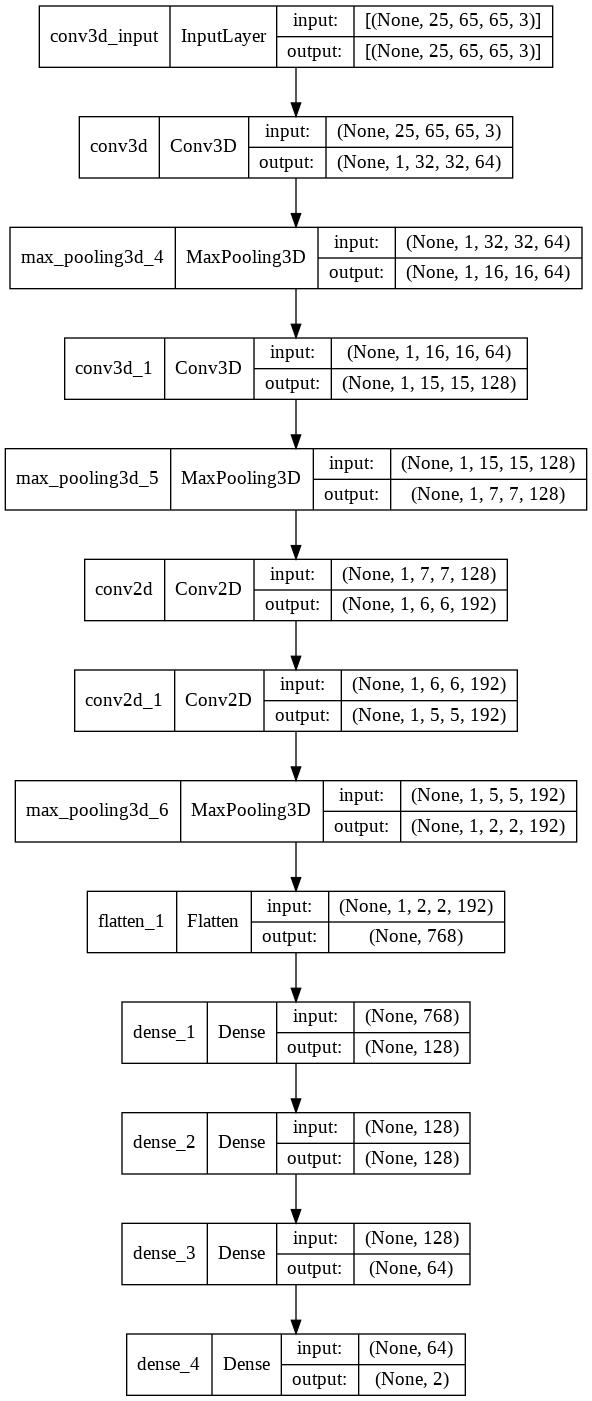

In [15]:
plot_model(conv_model, to_file='conv3D_model_architecture.jpg', show_shapes=True, show_layer_names=True)

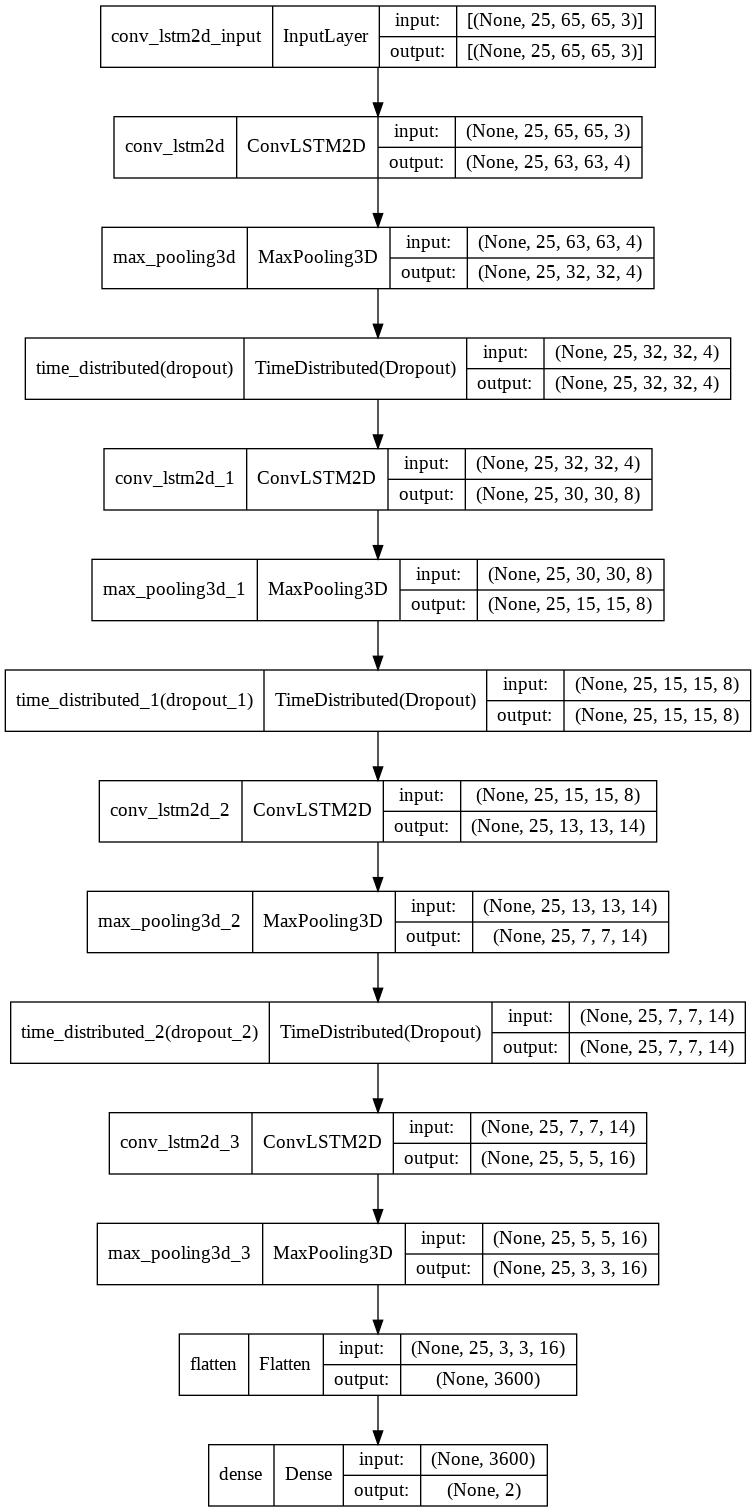

In [16]:
plot_model(cnnlstm_model, to_file = 'convlstm_model_structure_plot.jpg', show_shapes = True, show_layer_names = True)

In [18]:
# Training Begins.....

In [19]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
conv_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
conv_model_training_history = conv_model.fit(x = features_train, y = labels_train, epochs = 20, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2, 
                                                     callbacks = [early_stopping_callback])

Epoch 1/20
351/351 [==============================] - 28s 77ms/step - loss: 0.6784 - accuracy: 0.5869 - val_loss: 0.6778 - val_accuracy: 0.5726
Epoch 2/20
351/351 [==============================] - 26s 74ms/step - loss: 0.6695 - accuracy: 0.5976 - val_loss: 0.6859 - val_accuracy: 0.5726
Epoch 3/20
351/351 [==============================] - 26s 73ms/step - loss: 0.6770 - accuracy: 0.5976 - val_loss: 0.6832 - val_accuracy: 0.5726
Epoch 4/20
351/351 [==============================] - 26s 74ms/step - loss: 0.6779 - accuracy: 0.5976 - val_loss: 0.6825 - val_accuracy: 0.5726
Epoch 5/20
351/351 [==============================] - 26s 73ms/step - loss: 0.6748 - accuracy: 0.5976 - val_loss: 0.6849 - val_accuracy: 0.5726
Epoch 6/20
351/351 [==============================] - 26s 73ms/step - loss: 0.6752 - accuracy: 0.5976 - val_loss: 0.6827 - val_accuracy: 0.5726
Epoch 7/20
351/351 [==============================] - 26s 75ms/step - loss: 0.6748 - accuracy: 0.5976 - val_loss: 0.6831 - val_accuracy:

In [12]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
cnnlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
cnnlstm_model_history = cnnlstm_model.fit(x = features_train, y = labels_train, epochs = 20, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2, 
                                                     callbacks = [early_stopping_callback])

Epoch 1/20
351/351 [==============================] - 631s 2s/step - loss: 0.6717 - accuracy: 0.6011 - val_loss: 0.6583 - val_accuracy: 0.6325
Epoch 2/20
351/351 [==============================] - 606s 2s/step - loss: 0.6402 - accuracy: 0.6325 - val_loss: 0.6119 - val_accuracy: 0.6524
Epoch 3/20
351/351 [==============================] - 598s 2s/step - loss: 0.5835 - accuracy: 0.6923 - val_loss: 0.5767 - val_accuracy: 0.6923
Epoch 4/20
351/351 [==============================] - 597s 2s/step - loss: 0.5047 - accuracy: 0.7564 - val_loss: 0.5525 - val_accuracy: 0.7293
Epoch 5/20
351/351 [==============================] - 653s 2s/step - loss: 0.4581 - accuracy: 0.7835 - val_loss: 0.5270 - val_accuracy: 0.7721
Epoch 6/20
351/351 [==============================] - 668s 2s/step - loss: 0.3876 - accuracy: 0.8376 - val_loss: 0.6245 - val_accuracy: 0.7635
Epoch 7/20
351/351 [==============================] - 703s 2s/step - loss: 0.3500 - accuracy: 0.8369 - val_loss: 0.5585 - val_accuracy: 0.7749

In [13]:
model_evaluation_history = cnnlstm_model.evaluate(features_test, labels_test)

14/14 [==============================] - 35s 2s/step - loss: 0.4921 - accuracy: 0.7540


In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
print(model_file_name)
# Save your Model.
convlstm_model.save(model_file_name)

In [4]:
cnn_lstm_model = tf.keras.models.load_model("convlstm_model___Date_Time_2022_01_04__07_10_52___Loss_0.4543951153755188___Accuracy_0.7949886322021484.h5")

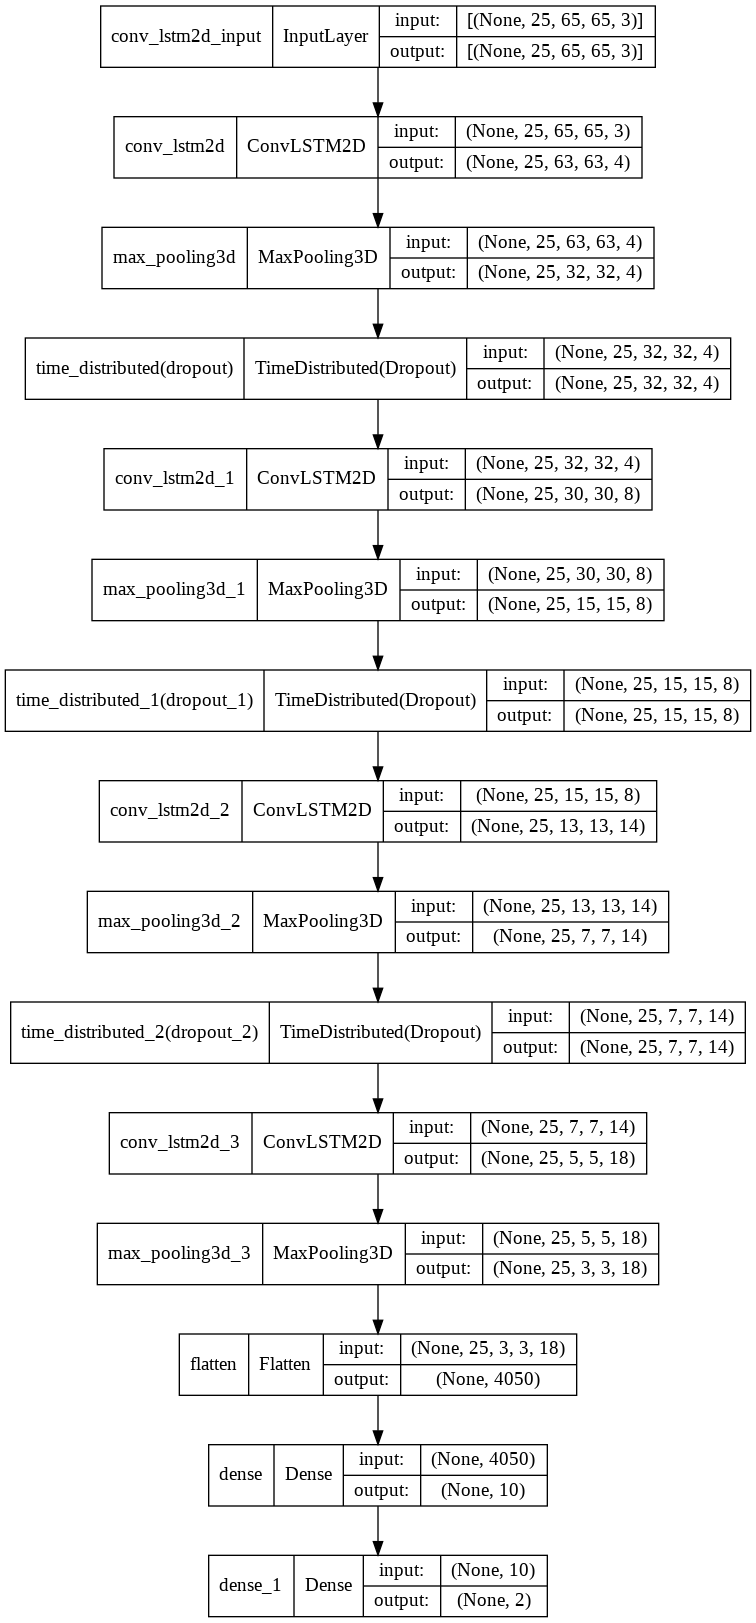

In [5]:
plot_model(cnn_lstm_model, show_shapes=True, show_layer_names=True)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
# TESTING THE MODEL ON PUBLIC TEST DATA

In [14]:
BASE_DIR = 'drive/MyDrive/Public_Test_Data'
CLASSES_LIST = ['non_scoring_clips', 'scoring_clips']

In [15]:
def create_test_dataset():
  features = []
  labels = []
  

  for index,class_name in enumerate(CLASSES_LIST):
    print(f'Extracting Data for {class_name}')

    video_files = os.listdir(os.path.join(BASE_DIR, class_name))

    for file in video_files:
      path = os.path.join(BASE_DIR, class_name, file)
      frames = frames_extraction(path)

      if len(frames)==SEQUENCE_LENGTH:
        features.append(frames)
        labels.append(index)
        

  
  features = np.array(features)
  labels = np.array(labels)

  return features, labels

In [16]:
features, labels = create_test_dataset()

Extracting Data for non_scoring_clips
Extracting Data for scoring_clips


In [17]:
encoded_test_labels = to_categorical(labels)

In [19]:
cnnlstm_model.evaluate(features, encoded_test_labels)

16/16 [==============================] - 41s 3s/step - loss: 0.5172 - accuracy: 0.7332


[0.5172094106674194, 0.7332015633583069]

In [24]:
# Model Accuracy For The Public Test Data is : 77.47%

In [23]:
training_accuracy = cnnlstm_model_history.history['accuracy']

No handles with labels found to put in legend.


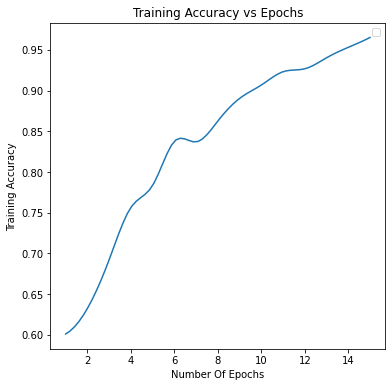

In [52]:
epochs = range(1, len(training_accuracy) + 1)

plt.figure(figsize=(6,6))
spl = make_interp_spline(epochs, training_accuracy, k=3)
x_new = np.linspace(1, 15, 70) 
y = spl(x_new)
plt.plot(x_new, y)
plt.title('Training Accuracy vs Epochs')
plt.xlabel("Number Of Epochs")
plt.ylabel("Training Accuracy")
plt.savefig('training_accuracy.jpg')
plt.legend()

In [54]:
training_loss = cnnlstm_model_history.history['loss']

No handles with labels found to put in legend.


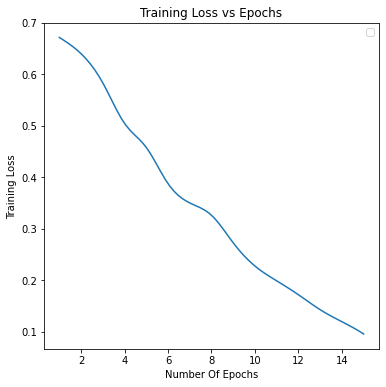

In [55]:
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(6,6))
spl = make_interp_spline(epochs, training_loss, k=3)
x_new = np.linspace(1, 15, 70) 
y = spl(x_new)
plt.plot(x_new, y)
plt.title('Training Loss vs Epochs')
plt.xlabel("Number Of Epochs")
plt.ylabel("Training Loss")
plt.savefig('training_loss.jpg')
plt.legend()

In [57]:
CNN_LSTM = tf.keras.models.load_model("convlstm_model___Date_Time_2022_01_04__07_10_52___Loss_0.4543951153755188___Accuracy_0.7949886322021484.h5")

In [58]:
CNN_LSTM.evaluate(features, encoded_test_labels)

16/16 [==============================] - 44s 3s/step - loss: 0.4749 - accuracy: 0.7747


[0.47485554218292236, 0.7747035622596741]

In [73]:
predictions = CNN_LSTM.predict(features)

In [74]:
predictions

array([[0.65059763, 0.34940237],
       [0.63450205, 0.365498  ],
       [0.94426346, 0.05573649],
       ...,
       [0.09209047, 0.9079095 ],
       [0.01175791, 0.9882421 ],
       [0.00386745, 0.9961326 ]], dtype=float32)

In [75]:
predicted_labels = []
for i in range(0, len(predictions)):
  if predictions[i][0] >= predictions[i][1]:
    predicted_labels.append(0)
  else:
    predicted_labels.append(1)

In [76]:
encoded_predicted_labels = to_categorical(predicted_labels)

In [77]:
print(metrics.classification_report(encoded_test_labels, encoded_predicted_labels))

              precision    recall  f1-score   support

           0       0.84      0.75      0.79       291
           1       0.70      0.81      0.75       215

   micro avg       0.77      0.77      0.77       506
   macro avg       0.77      0.78      0.77       506
weighted avg       0.78      0.77      0.78       506
 samples avg       0.77      0.77      0.77       506



In [91]:
# Plotting The ROC Curve for our Model based on predictions made on Public Test Data

In [87]:
fpr, tpr, thresholds = metrics.roc_curve(labels, predicted_labels)

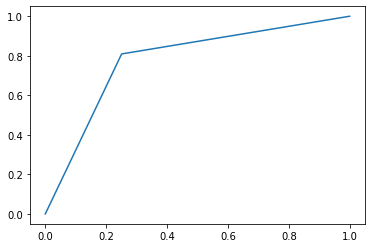

In [88]:
plt.plot(fpr, tpr)

In [90]:
# Calculating The AUC for Our Model based on predictions made on Public Test Data

In [92]:
metrics.auc(fpr,tpr)

0.7792216095260929